In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/My\ Drive/New\ Dataset /content/Dataset

In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, concatenate, LeakyReLU

import random as rn
import numpy as np
import pandas as pd

In [4]:
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#K.set_session(sess)
tf.compat.v1.keras.backend.set_session(sess)

**Load data**

Load train data.

In [6]:
train_image_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255
)
batchsize = 380
train_image_generator = train_image_datagen.flow_from_directory(
  directory = "/content/Dataset/train",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = False,
  class_mode = 'categorical'
)

train_images, train_labels = next(train_image_generator)

# Get images order
image_files = pd.Series(train_image_generator.filenames)
image_files = list(image_files.str[:-4])
print(image_files)

# Sort tabular data
train_tabular_data = pd.read_csv('train_data.csv')
train_tabular_data = train_tabular_data.sort_values('Id')
print(train_tabular_data.head())
train_tabular_data = train_tabular_data.drop(['Id'], axis=1)
print(train_tabular_data.head())

Found 380 images belonging to 3 classes.
['Bathroom/007db7e01f3941d2', 'Bathroom/00b8c7642d98fedf', 'Bathroom/00bf3b7340ae0a9f', 'Bathroom/015484347eacc20d', 'Bathroom/0168686b82b426e2', 'Bathroom/01bca544d1768a84', 'Bathroom/02a945cc2b6f4daf', 'Bathroom/02c773a25a15f7cd', 'Bathroom/0303fb65c4c9a7e1', 'Bathroom/0365d8d1d967a2fc', 'Bathroom/036b5adbc5c06df2', 'Bathroom/0416d14707884715', 'Bathroom/0567c0fbc7387c23', 'Bathroom/078e2e18f0e748ce', 'Bathroom/07c65844865ad91f', 'Bathroom/0816a46ef71fa4c3', 'Bathroom/089d0bc3ec234cb0', 'Bathroom/09542b695d7802a5', 'Bathroom/0b0803480232cf3e', 'Bathroom/0ba97be2c7011295', 'Bathroom/0be49fe17e959264', 'Bathroom/0bf06163bd011f7f', 'Bathroom/0c71c87e710acf06', 'Bathroom/0d78b275aa2d01ed', 'Bathroom/0e1b7b2038436056', 'Bathroom/0ece5b3baf9dc5c2', 'Bathroom/10085be0a892b552', 'Bathroom/107d06238ba3e314', 'Bathroom/10c08673bb67eb04', 'Bathroom/13bb7f5603f0aa4c', 'Bathroom/16ca9aa7cf522c51', 'Bathroom/1706c70c0576fc2f', 'Bathroom/1797c012d8d18a4e', '

Load validation data.

In [7]:
valid_image_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255
)
batchsize = 63
valid_image_generator = valid_image_datagen.flow_from_directory(
  directory = "/content/Dataset/validation",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = False,
  class_mode = 'categorical'
)

valid_images, valid_labels = next(valid_image_generator)

# Get images order
image_files = pd.Series(valid_image_generator.filenames)
image_files = list(image_files.str[:-4])
print(image_files)

# Sort tabular data
valid_tabular_data = pd.read_csv('validation_data.csv')
valid_tabular_data = valid_tabular_data.sort_values('Id')
print(valid_tabular_data.head())
valid_tabular_data = valid_tabular_data.drop(['Id'], axis=1)
print(valid_tabular_data.head())

Found 63 images belonging to 3 classes.
['Bathroom/02e40117749a7324', 'Bathroom/09025e8df61fa4d2', 'Bathroom/0dd28180c8b06ac1', 'Bathroom/0ffc7dc38427be4d', 'Bathroom/1680badd9e14c39c', 'Bathroom/1b80f8d3658d5146', 'Bathroom/1feee75d0cd8b08c', 'Bathroom/2eb5f812b486c547', 'Bathroom/310e83a9b625b44a', 'Bathroom/3db7cd79c0d280ca', 'Bathroom/40e3252f39eee5d3', 'Bathroom/416afb9920bce870', 'Bathroom/4ace71b7fc371125', 'Bathroom/539e0871494dea5d', 'Bathroom/6083d38479f8629a', 'Bathroom/87a2efb71f01196a', 'Bathroom/903863dca3cf21fa', 'Bathroom/9526a7f097f44677', 'Bathroom/9786143f704f76ae', 'Bathroom/df9e7b020cfcd77f', 'Bathroom/f9121ce29187360b', 'Bedroom/0321c2f0d50671e8', 'Bedroom/06d231feb0e1f7ed', 'Bedroom/09c96a274fd701f7', 'Bedroom/2135873468f50b33', 'Bedroom/221060fddd44f93e', 'Bedroom/2248eecea69fedc3', 'Bedroom/2f815007d760d135', 'Bedroom/44e4c2e081894be1', 'Bedroom/5400c9e9f81e834b', 'Bedroom/5e2fbec160429df4', 'Bedroom/630e16cede80c59c', 'Bedroom/7faf63a0d79ab8df', 'Bedroom/82ebc

**Model Definition**

Define individual models for extracting features in images (CNN model) and for extracting features from tabular data (MLP model).

In [29]:
def create_cnn():
  vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
  for layer in vgg_model.layers:
    layer.trainable = False
  vgg_model.trainable = False
  x = Flatten(name="flatten")(vgg_model.output)
  x = Dense(32)(x)
  x = LeakyReLU(alpha=0.3)(x)
  x = Dropout(0.5)(x)
  x = Dense(4)(x)
  x = LeakyReLU(alpha=0.3)(x)

  cnn_model = Model(vgg_model.input, x)
  return cnn_model

def create_mlp(dim):
    mlp_model = Sequential()
    mlp_model.add(Dense(8, input_dim=dim))
    mlp_model.add(LeakyReLU(alpha=0.3))
    mlp_model.add(Dense(4))
    mlp_model.add(LeakyReLU(alpha=0.3))
    return mlp_model

Build concatenated model.

In [30]:
cnn_model = create_cnn()
mlp_model = create_mlp(train_tabular_data.shape[1])
print(train_tabular_data.shape[1])

concat_model = concatenate([mlp_model.output, cnn_model.output])

classification_model = Dense(8, activation="relu")(concat_model)
classification_model = Dropout(0.25)(classification_model)
classification_model = Dense(3, activation="softmax")(classification_model)

model = Model(inputs=[mlp_model.input, cnn_model.input], outputs=classification_model)

model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-4),
      loss=keras.losses.categorical_crossentropy,
      metrics=['accuracy'])

model.summary()

7
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________

**Training**

Apply weights to balance data.

In [23]:
def get_class_weight():
  bathroom = 133
  bedroom = 134
  kitchen = 113
  total = bathroom + bedroom + kitchen
  class_weight = {0: total / bathroom, 1: total / bedroom, 2: total / kitchen}
  return class_weight

Train model.

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('vgg_{epoch:03d}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, save_freq='epoch')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

training = model.fit(
  [train_tabular_data, train_images], 
  train_labels,
  callbacks=[checkpoint, early_stopping],
  validation_data=([valid_tabular_data, valid_images], valid_labels), 
  epochs=100, 
  batch_size=10,
  class_weight=get_class_weight(),
  verbose=1,
)

Epoch 1/100
38/38 [==============================] - 4s 79ms/step - loss: 3.2492 - accuracy: 0.3741 - val_loss: 1.0457 - val_accuracy: 0.3968

Epoch 00001: val_accuracy improved from -inf to 0.39683, saving model to vgg_001.h5
Epoch 2/100
38/38 [==============================] - 3s 72ms/step - loss: 3.1003 - accuracy: 0.4135 - val_loss: 1.0007 - val_accuracy: 0.4921

Epoch 00002: val_accuracy improved from 0.39683 to 0.49206, saving model to vgg_002.h5
Epoch 3/100
38/38 [==============================] - 3s 72ms/step - loss: 2.9211 - accuracy: 0.4561 - val_loss: 0.8401 - val_accuracy: 0.5397

Epoch 00003: val_accuracy improved from 0.49206 to 0.53968, saving model to vgg_003.h5
Epoch 4/100
38/38 [==============================] - 3s 72ms/step - loss: 2.7218 - accuracy: 0.4664 - val_loss: 0.8544 - val_accuracy: 0.5714

Epoch 00004: val_accuracy improved from 0.53968 to 0.57143, saving model to vgg_004.h5
Epoch 5/100
38/38 [==============================] - 3s 72ms/step - loss: 2.5512 - 

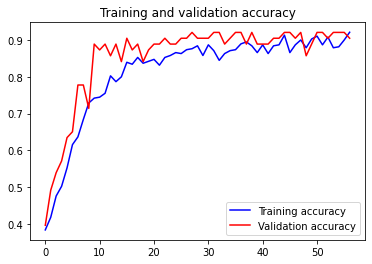

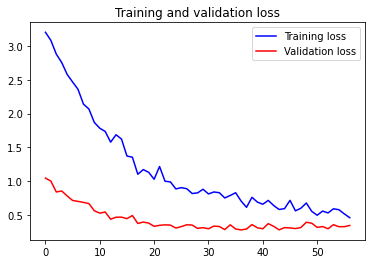

In [33]:
accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
loss = training.history['loss']
val_loss = training.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Evaluation**

Load trained model.

In [34]:
model = load_model('vgg_028.h5')

Get test data.

In [35]:
test_image_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rescale=1./255
)
batchsize = 82
test_image_generator = test_image_datagen.flow_from_directory(
  directory = "/content/Dataset/test",
  target_size = (256, 256),
  batch_size = batchsize,
  shuffle = False,
  class_mode = 'categorical'
)

test_images, test_labels = next(test_image_generator)

# Get images order
image_files = pd.Series(test_image_generator.filenames)
image_files = list(image_files.str[:-4])
print(image_files)

# Sort tabular data
test_tabular_data = pd.read_csv('test_data.csv')
test_tabular_data = test_tabular_data.sort_values('Id')
print(test_tabular_data.head())
test_tabular_data = test_tabular_data.drop(['Id'], axis=1)
print(test_tabular_data.head())

Found 82 images belonging to 3 classes.
['Bathroom/02715c046c3d471a', 'Bathroom/047c7dabc16d35af', 'Bathroom/06692f725a5b701f', 'Bathroom/0670f374cb492edc', 'Bathroom/086fc364b95665cf', 'Bathroom/08c43f3723264dc4', 'Bathroom/0b89b640ff87bcf7', 'Bathroom/0bbe8bb88a6e0509', 'Bathroom/0fe63b10a0b4ca12', 'Bathroom/19184297dd1f706d', 'Bathroom/1cc82e1c9ab888ba', 'Bathroom/2b7f0eb8153ef7bc', 'Bathroom/3b11341d338060d9', 'Bathroom/4578d572d50dd369', 'Bathroom/47ab0e73c33bdefd', 'Bathroom/4fb76103c9dc4c8d', 'Bathroom/5fa967729ccef74d', 'Bathroom/77525ddb3b77cc02', 'Bathroom/785381c2ad10e66f', 'Bathroom/9043670ac3b9094d', 'Bathroom/ad418899d68f69bf', 'Bathroom/b008536da9781b75', 'Bathroom/b5192bf17ba46344', 'Bathroom/bac968ef33ddb986', 'Bathroom/ddd3f96ff7f0bc78', 'Bedroom/01eab6736c66f762', 'Bedroom/0422398e5e607a2b', 'Bedroom/06ae040c8af68a59', 'Bedroom/08530075bffc70a7', 'Bedroom/0af835183c8d6777', 'Bedroom/0c9cbf4e69f9f710', 'Bedroom/0e540b713b49e598', 'Bedroom/120755e65198a759', 'Bedroom/1

In [36]:
results = model.evaluate([test_tabular_data, test_images], test_labels)
print(results)
predictions = model.predict([test_tabular_data, test_images])
predictions = np.argmax(predictions, axis=1)
print(classification_report(test_image_generator.classes, predictions,
	target_names=test_image_generator.class_indices.keys()))
print(confusion_matrix(test_image_generator.classes, predictions))

3/3 [==============================] - 1s 134ms/step - loss: 0.3032 - accuracy: 0.9390
[0.3031935691833496, 0.9390243887901306]
              precision    recall  f1-score   support

    Bathroom       0.89      1.00      0.94        25
     Bedroom       0.97      0.95      0.96        37
     Kitchen       0.94      0.85      0.89        20

    accuracy                           0.94        82
   macro avg       0.94      0.93      0.93        82
weighted avg       0.94      0.94      0.94        82

[[25  0  0]
 [ 1 35  1]
 [ 2  1 17]]


**Tabular Data from annotations**

This section is to build the tabular data used in the concatenated model from annotations, while the object detection is not complete.


In [26]:
import os
class_names = ['Bathroom', 'Bedroom', 'Kitchen']
dataset = 'validation'

csv_columns = ['Id', 'Bathtub', 'Bed', 'Oven', 'Refrigerator', 'Sink', 'Toilet', 'Window']
tabular_data = []

for c in class_names:
  filenames = os.listdir('Dataset/GroundTruth/' + dataset + '/' + c)
  print(filenames)

  for fname in filenames:
    obj_dict = {
      'Id': c + '/' + fname[:-4],
      'Bathtub': 0,
      'Bed': 0,
      'Oven': 0,
      'Refrigerator': 0,
      'Sink': 0,
      'Toilet': 0,
      'Window': 0
    }
    f = open('Dataset/GroundTruth/' + dataset + '/' + c + '/' + fname, "r")
    labels = f.read().split('\n')
    labels = list(filter(None, labels))
    for label in labels:
      label = label.split(' ')
      obj = label[0]
      obj_dict[obj] += 1
    tabular_data.append(obj_dict)

print(tabular_data)

['0dd28180c8b06ac1.txt', '4ace71b7fc371125.txt', '310e83a9b625b44a.txt', '0ffc7dc38427be4d.txt', 'f9121ce29187360b.txt', '09025e8df61fa4d2.txt', '1680badd9e14c39c.txt', 'df9e7b020cfcd77f.txt', '1b80f8d3658d5146.txt', '2eb5f812b486c547.txt', '02e40117749a7324.txt', '6083d38479f8629a.txt', '87a2efb71f01196a.txt', '3db7cd79c0d280ca.txt', '539e0871494dea5d.txt', '40e3252f39eee5d3.txt', '1feee75d0cd8b08c.txt', '416afb9920bce870.txt', '903863dca3cf21fa.txt', '9786143f704f76ae.txt', '9526a7f097f44677.txt']
['91bf748ab4455715.txt', '2135873468f50b33.txt', '92e26be52b8cde88.txt', '5400c9e9f81e834b.txt', '06d231feb0e1f7ed.txt', '221060fddd44f93e.txt', '2f815007d760d135.txt', '2248eecea69fedc3.txt', '9a600aae8c04f928.txt', '09c96a274fd701f7.txt', '87ba23843a5477cb.txt', '7faf63a0d79ab8df.txt', '0321c2f0d50671e8.txt', '630e16cede80c59c.txt', 'b833ff7e8c121fd4.txt', '44e4c2e081894be1.txt', '5e2fbec160429df4.txt', '82ebc6a99f41f24c.txt']
['0896f7f8ba671953.txt', 'd87f2ce076230974.txt', '2b87c3313f02

Save data to csv.

In [27]:
import csv

csv_file = dataset + '_data.csv'

with open(csv_file, 'w') as csvfile:
  writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
  writer.writeheader()
  for data in tabular_data:
    writer.writerow(data)